In [18]:
# Import necessary libraries and tools
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
import matplotlib.pyplot as plt
import numpy as np


Starting epoch 1


In [19]:
# Set up data loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Starting epoch 2


In [20]:
# Define the quantum circuit
n_qubits = 4
qc = QuantumCircuit(n_qubits)
theta = [Parameter(f'theta_{i}') for i in range(n_qubits)]
phi = Parameter('phi')
for i in range(n_qubits):
    qc.h(i)
    qc.rx(theta[i], i)
qc.ry(phi, 0)  
qc.measure_all()
print("Starting epoch 3")


Starting epoch 3


In [21]:
# Set up the quantum neural network
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)
circuit_qnn = CircuitQNN(circuit=qc, input_params=theta, weight_params=[phi], quantum_instance=quantum_instance)
quantum_layer = TorchConnector(circuit_qnn, np.product(trainloader.dataset[0][0].shape))


Starting epoch 4


/tmp/ipykernel_307/2198768836.py:1: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)


In [22]:
# Define the hybrid quantum-classical neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 4)
        self.quantum_layer = quantum_layer
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Train the model (it takes a while)
epochs = 1
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader)}")

Epoch 1/1 - Loss: 2.30265963941749


Accuracy on test data: 11.35%


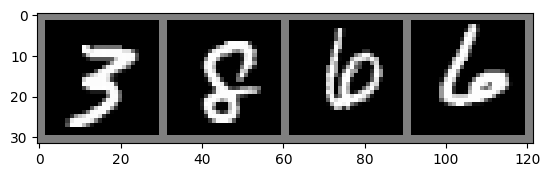

GroundTruth:      3     8     6     6
Predicted:        1     1     1     1


In [24]:
#  Evaluate and visualize the model's predictions
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

accuracy = evaluate_model(model, testloader)
print(f"Accuracy on test data: {accuracy*100:.2f}%")

dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))
print('Predicted:   ', ' '.join('%5s' % predicted[j].item() for j in range(4)))
